# Portfolio Project: Plant Disease Classifier

**Task:** Detect if the leaf image is healthy or unhealthy. If the leaf is ill, what type of disease is it ?


**Dataset:**

  * **Name:** Plant_Village
  * **Description:** The PlantVillage dataset consists of 54303 healthy and unhealthy leaf images divided into 38 categories by species and disease.
  * **Website:** *tensorflow datasets*
  * **Where to find data:** https://www.tensorflow.org/datasets/catalog/plant_village



In [ ]:
import sklearn
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import tensorflow_datasets as tfds
from tensorflow.keras import layers

In [ ]:
# List all availiable Datasets
availiable_datasets_list = tfds.list_builders() # get all availiable datasets in TFDS

print('plant_village' in availiable_datasets_list)

True


In [ ]:
# Load in the Data (takes 3-4 min in Google Colab)

full_data, ds_info = tfds.load(name='plant_village',
                               split='train', # dataset has only train split, so we will have to split data manually into train and test
                               shuffle_files=True, # we will need to shuffle data because we will be splitting data into train and test splits
                               as_supervised=True, # data gets returned in the form of tuples (img, label)
                               with_info=True) # will help us to get class names

In [ ]:
# we get data in the format of tf.data.Dataset
full_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# data is not batched
len(full_data)

54303

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=38),
})

In [ ]:
# get class names
class_names = ds_info.features['label'].names

class_names[:10], len(class_names)

(['Apple___Apple_scab',
  'Apple___Black_rot',
  'Apple___Cedar_apple_rust',
  'Apple___healthy',
  'Blueberry___healthy',
  'Cherry___healthy',
  'Cherry___Powdery_mildew',
  'Corn___Cercospora_leaf_spot Gray_leaf_spot',
  'Corn___Common_rust',
  'Corn___healthy'],
 38)

## Visualize data

In [ ]:
visual_sample = full_data.take(4)

for image, label in visual_sample:
  print(f'Image: {image.shape, image.dtype}') # check image shape and dtype
  print(f'Label: {label.shape, label.dtype}') # check if image is OneHot or Label encoded
  print(tf.reduce_min(image), tf.reduce_max(image))

Image: (TensorShape([256, 256, 3]), tf.uint8)
Label: (TensorShape([]), tf.int64)
tf.Tensor(0, shape=(), dtype=uint8) tf.Tensor(255, shape=(), dtype=uint8)
Image: (TensorShape([256, 256, 3]), tf.uint8)
Label: (TensorShape([]), tf.int64)
tf.Tensor(0, shape=(), dtype=uint8) tf.Tensor(197, shape=(), dtype=uint8)
Image: (TensorShape([256, 256, 3]), tf.uint8)
Label: (TensorShape([]), tf.int64)
tf.Tensor(0, shape=(), dtype=uint8) tf.Tensor(246, shape=(), dtype=uint8)
Image: (TensorShape([256, 256, 3]), tf.uint8)
Label: (TensorShape([]), tf.int64)
tf.Tensor(0, shape=(), dtype=uint8) tf.Tensor(255, shape=(), dtype=uint8)


In [ ]:
# we will take only 1000 images for visualization instead of 54000, it will save us time and compute resources
visual_sample_data = full_data.take(1000)

len(visual_sample_data)

1000

In [ ]:
# We will unbatch our tf.data.Dataset, so that we could visualize our images
unbatch_images = []
unbatch_labels = []

for image, label in visual_sample_data:
  unbatch_images.append(image)
  unbatch_labels.append(label)

len(unbatch_images), len(unbatch_labels)

(1000, 1000)

In [ ]:
# Create function to randomly visualize images
def plot_plant_image(images, labels, num_images, class_names):
  fig = plt.figure()
  for i in range(num_images):
    cnum = int(np.random.randint(0, len(images), 1))
    name = class_names[int(labels[cnum])]
    ax = fig.add_subplot(3, 3, i + 1)

    ax.imshow(images[cnum])
    ax.set_title(f'{name}', fontsize=6)
    ax.axis('off');

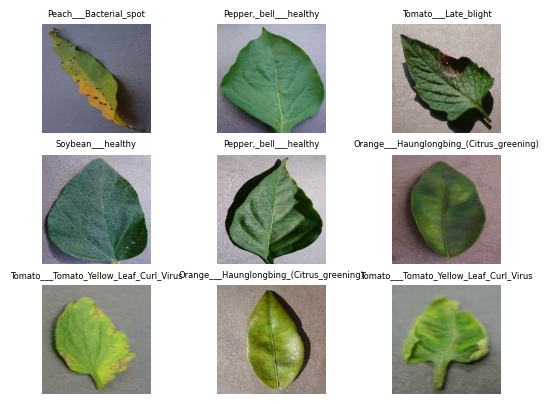

In [ ]:
plot_plant_image(unbatch_images, unbatch_labels, 9, class_names)

## Split and Preprocess data

In [ ]:
# We need to get a number that will split full_data into train_split -> 80% and test split -> 20% of data
split_size = int(0.8 * len(full_data))

len(full_data), split_size

(54303, 43442)

In [ ]:
# split data into train and test splits
train_data = full_data.take(split_size)

test_data = full_data.skip(split_size)

len(train_data), len(test_data)

(43442, 10861)

In [ ]:
# Create a preprocessing function that will help us shape input_data into the desired form
def preprocess_function_scale(image, label, img_size=224):
  image = tf.image.resize(image, size=(img_size, img_size)) # resize images into shape (224, 224, 3)

  image = tf.cast(image, dtype=tf.float32) # change data dtype into float32 (tf. loves data in the float32 format)

  image = image / 255. # scale data (increase training speed and accuracy)

  return image, label

In [ ]:
# Prepare datasets (map preprocessing function, shuffle, batch and prefetch)

# train data
train_data_prep = train_data.map(map_func=preprocess_function_scale, num_parallel_calls=tf.data.AUTOTUNE)

train_data_prep = train_data_prep.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# test_data
test_data_prep = test_data.map(map_func=preprocess_function_scale, num_parallel_calls=tf.data.AUTOTUNE)

test_data_prep = test_data_prep.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data_prep, test_data_prep

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Build Models

We will create several models and see wich one is performing better:

1. Simple CNN model
2. Transfer Learning ResNet
3. Transfer Learning EffNet

### Simple CNN model

In [ ]:
from tensorflow.keras import layers

In [ ]:
# Build CNN model

inputs = layers.Input(shape=(224, 224, 3), dtype=tf.float32)

x = layers.Conv2D(32, 3, padding='same')(inputs)
x = layers.Conv2D(32, 3, padding='same')(x)
x = layers.Conv2D(32, 3, padding='same')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 3, padding='same')(x)
x = layers.Conv2D(64, 3, padding='same')(x)
x = layers.Conv2D(64, 3, padding='same')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 3, padding='same')(x)
x = layers.Conv2D(128, 3, padding='same')(x)
x = layers.Conv2D(128, 3, padding='same')(x)
x = layers.MaxPool2D()(x)

# x = layers.Conv2D(256, 3, padding='same')(x)
# x = layers.Conv2D(256, 3, padding='same')(x)
# x = layers.Conv2D(256, 3, padding='same')(x)
# x = layers.MaxPool2D()(x)

x = layers.GlobalMaxPool2D()(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model_1 = tf.keras.Model(inputs, outputs, name='model_1_CNN')

In [ ]:
# Compile model

model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(), # We have numericaly encoded labels, so we need use SparseCategoricalCrossentropy
                metrics=['accuracy'])

In [ ]:
# Get the summary of our model
model_1.summary()

Model: "model_1_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      18496     
                                                       

In [ ]:
history_1 = model_1.fit(train_data_prep,
                        steps_per_epoch=int(0.2 * len(train_data_prep)), # We will train only 20% of the data to make training time shorter
                        epochs=5,
                        validation_data=test_data_prep,
                        validation_steps=int(0.2 * len(test_data_prep))) # same for the validation data

Epoch 1/5
271/271 [==============================] - 97s 283ms/step - loss: 2.6764 - accuracy: 0.3014 - val_loss: 1.9384 - val_accuracy: 0.4582
Epoch 2/5
271/271 [==============================] - 76s 281ms/step - loss: 1.6211 - accuracy: 0.5469 - val_loss: 1.1553 - val_accuracy: 0.6751
Epoch 3/5
271/271 [==============================] - 94s 348ms/step - loss: 1.1057 - accuracy: 0.6778 - val_loss: 0.9584 - val_accuracy: 0.7233
Epoch 4/5
271/271 [==============================] - 76s 281ms/step - loss: 0.8885 - accuracy: 0.7393 - val_loss: 0.8404 - val_accuracy: 0.7560
Epoch 5/5
271/271 [==============================] - 76s 281ms/step - loss: 0.7997 - accuracy: 0.7627 - val_loss: 0.7019 - val_accuracy: 0.7872


In [ ]:
# evaluate on the 100% of the test data
model_1.evaluate(test_data_prep)

340/340 [==============================] - 39s 64ms/step - loss: 0.7006 - accuracy: 0.7905


[0.7006127238273621, 0.7905349135398865]

### Prepare data for the Transfer Learning Models

In [ ]:
# Most transfer learning models have their own normalization layers, so we won't need to scale data this time
def preprocess_function_no_scale(image, label, img_shape=224):
  image = tf.image.resize(image, size=(img_shape, img_shape))

  return tf.cast(image, dtype=tf.float32), label

In [ ]:
# Prepare data for transfer learning models

# train data
train_data_transfer = train_data.map(map_func=preprocess_function_no_scale, num_parallel_calls=tf.data.AUTOTUNE)

train_data_transfer = train_data_transfer.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# test_data
test_data_transfer = test_data.map(map_func=preprocess_function_no_scale, num_parallel_calls=tf.data.AUTOTUNE)

test_data_transfer = test_data_transfer.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data_transfer, test_data_transfer

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

### Transfer Learning ResNet (Feature extractor)

In [ ]:
base_model_res = tf.keras.applications.resnet50.ResNet50(include_top=False)
base_model_res.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
inputs = layers.Input(shape=(224, 224, 3), dtype=tf.float32)

x = tf.keras.applications.resnet50.preprocess_input(inputs) # use resnet's preprocess function to get data into the correct form

x = base_model_res(x, training=False)

x = layers.GlobalMaxPool2D()(x)

outputs = layers.Dense(units=len(class_names), activation='softmax')(x)

model_2 = tf.keras.Model(inputs, outputs, name='model_2_ResNet')

In [ ]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "model_2_ResNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_1 (Dense)             (None, 38)             

In [ ]:
history_2 = model_2.fit(train_data_transfer,
                        steps_per_epoch=int(0.2 * len(train_data_transfer)),
                        epochs=5,
                        validation_data=test_data_transfer,
                        validation_steps=int(0.2 * len(test_data_transfer)))

Epoch 1/5
271/271 [==============================] - 59s 191ms/step - loss: 1.7479 - accuracy: 0.7339 - val_loss: 0.5128 - val_accuracy: 0.8952
Epoch 2/5
271/271 [==============================] - 67s 250ms/step - loss: 0.5961 - accuracy: 0.8870 - val_loss: 0.4528 - val_accuracy: 0.9085
Epoch 3/5
271/271 [==============================] - 68s 250ms/step - loss: 0.4809 - accuracy: 0.9158 - val_loss: 0.4789 - val_accuracy: 0.9035
Epoch 4/5
271/271 [==============================] - 68s 250ms/step - loss: 0.4669 - accuracy: 0.9230 - val_loss: 0.3931 - val_accuracy: 0.9426
Epoch 5/5
271/271 [==============================] - 51s 189ms/step - loss: 0.4096 - accuracy: 0.9312 - val_loss: 0.3360 - val_accuracy: 0.9407


In [ ]:
model_2.evaluate(test_data_transfer)

### Transfer Learning EffNet (Feature extractor)

In [ ]:
base_model_eff = tf.keras.applications.EfficientNetB0(include_top=False)
base_model_eff.trainable = False

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
inputs = layers.Input(shape=(224, 224, 3), dtype=tf.float32)

x = base_model_eff(inputs, training=False) # effnet has rescaling layer included in the model architecture

x = layers.GlobalMaxPool2D()(x)

outputs = layers.Dense(units=len(class_names), activation='softmax')(x)

model_3 = tf.keras.Model(inputs, outputs, name='model_3_EffNet')

In [ ]:
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

In [ ]:
model_3.summary()

Model: "model_3_EffNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 38)                48678     
                                                                 
Total params: 4,098,249
Trainable params: 48,678
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
history_3 = model_3.fit(train_data_transfer,
                        steps_per_epoch=int(0.2 * len(train_data_transfer)),
                        epochs=5,
                        validation_data=test_data_transfer,
                        validation_steps=int(0.2 * len(test_data_transfer)))

Epoch 1/5
271/271 [==============================] - 80s 222ms/step - loss: 1.3921 - accuracy: 0.6857 - val_loss: 0.5515 - val_accuracy: 0.8447
Epoch 2/5
271/271 [==============================] - 59s 217ms/step - loss: 0.4829 - accuracy: 0.8578 - val_loss: 0.4064 - val_accuracy: 0.8906
Epoch 3/5
271/271 [==============================] - 58s 215ms/step - loss: 0.3348 - accuracy: 0.9044 - val_loss: 0.2950 - val_accuracy: 0.9154
Epoch 4/5
271/271 [==============================] - 41s 150ms/step - loss: 0.3350 - accuracy: 0.9042 - val_loss: 0.3491 - val_accuracy: 0.9085
Epoch 5/5
271/271 [==============================] - 58s 214ms/step - loss: 0.3042 - accuracy: 0.9161 - val_loss: 0.2665 - val_accuracy: 0.9380


In [ ]:
model_3.evaluate(test_data_transfer)

340/340 [==============================] - 38s 60ms/step - loss: 0.2602 - accuracy: 0.9300


[0.2601902484893799, 0.9300248622894287]

## Try to Improve on our best model

Fine-tune and train for 5 more epochs

We will fine-tune EffNet (even if it has lower `val_accuracy` compare to ResNet) because it has lower number of weights to train and it has overall better performance on the `val_loss`.

In [ ]:
# Check what layers we have in our model
model_3.layers

In [ ]:
# Are these layers trainable ?
for layer in model_3.layers:
  print(layer, layer.trainable)


<keras.engine.input_layer.InputLayer object at 0x7c36e5f8e560> True
<keras.engine.functional.Functional object at 0x7c36e5f8d690> False
<keras.layers.pooling.global_max_pooling2d.GlobalMaxPooling2D object at 0x7c36f4b0ac80> True
<keras.layers.core.dense.Dense object at 0x7c37a03bf010> True


In [ ]:
# What layers are in our base model and are they trainable ?
for i, layer in enumerate(model_3.layers[1].layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
# Count how many trainable layers our model has
print(len(model_3.layers[1].trainable_variables))

0


**Note:** We have 0 trainable layers in our base model because our EffNet model is 'frozen' and does not learn any patterns during training.

In order to fine-tune our model, we should unfreeze some or all layers in our model.

In [ ]:
# To begin fine-tuning we will set the last 20 layers of our base_model trainable = True
base_model_eff.trainable = True

for layer in base_model_eff.layers[:-20]:
  layer.trainable = False

# Recompile (we have to recompile our model each time we are making changes to our model)
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # because we are fine-tuning our model we would like to lower our learning rate by 10x
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

In [ ]:
# Check what layers are tunable (trainable)
for i, layer in enumerate(model_3.layers[1].layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
# Count how many trainable layers our model has
print(len(model_3.layers[1].trainable_variables)) # we have 19 not 20 because one layer does not have parameters (weights) to train

19


In [ ]:
history_3_fine_tune = model_3.fit(train_data_transfer,
                                  steps_per_epoch=int(0.2 * len(train_data_transfer)),
                                  epochs=9,
                                  validation_data=test_data_transfer,
                                  validation_steps=int(0.2 * len(test_data_transfer)),
                                  initial_epoch=history_3.epoch[-1]) # start training from the last extractor epoch

Epoch 5/9
271/271 [==============================] - 55s 158ms/step - loss: 0.1271 - accuracy: 0.9604 - val_loss: 0.1190 - val_accuracy: 0.9609
Epoch 6/9
271/271 [==============================] - 40s 150ms/step - loss: 0.0926 - accuracy: 0.9705 - val_loss: 0.1048 - val_accuracy: 0.9609
Epoch 7/9
271/271 [==============================] - 41s 151ms/step - loss: 0.0706 - accuracy: 0.9781 - val_loss: 0.0794 - val_accuracy: 0.9724
Epoch 8/9
271/271 [==============================] - 60s 221ms/step - loss: 0.0714 - accuracy: 0.9766 - val_loss: 0.0750 - val_accuracy: 0.9747
Epoch 9/9
271/271 [==============================] - 60s 222ms/step - loss: 0.0618 - accuracy: 0.9788 - val_loss: 0.0647 - val_accuracy: 0.9779


In [ ]:
model_3.evaluate(test_data_transfer)

340/340 [==============================] - 39s 58ms/step - loss: 0.0764 - accuracy: 0.9746


[0.07639213651418686, 0.9745879769325256]

## Test our best Model

In [ ]:
len(test_data_transfer)

340

In [ ]:
sample_data = test_data_transfer.take(30)

len(sample_data)

30

In [ ]:
unbatch_sample_images = []
unbatch_sample_labels = []

for image, label in sample_data.unbatch():
  unbatch_sample_images.append(image)
  unbatch_sample_labels.append(label)

len(unbatch_sample_images), len(unbatch_sample_labels)

(960, 960)

In [ ]:
# Create a function to make and plot prediction
def pred_plot_image(model, images, labels, class_names):

  num = np.random.randint(0, len(images))
  pred_probs = model.predict(tf.expand_dims(images[num], axis=0))
  pred_label = int(tf.argmax(pred_probs, axis=1))
  image = images[num] / 255.

  plt.figure()
  plt.imshow(image)
  plt.title(f'True Label: {class_names[labels[num].numpy()]} - {labels[num].numpy()}\nPred Label: {class_names[pred_label]} - {pred_label}')
  plt.axis('off')


In [ ]:
class_names[:3], len(class_names)

(['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust'], 38)

1/1 [==============================] - 0s 27ms/step


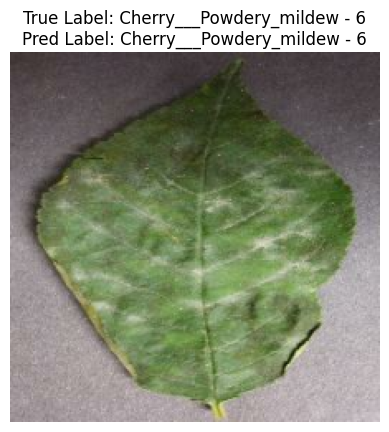

In [ ]:
pred_plot_image(model_3, unbatch_sample_images, unbatch_sample_labels, class_names)

1/1 [==============================] - 0s 26ms/step


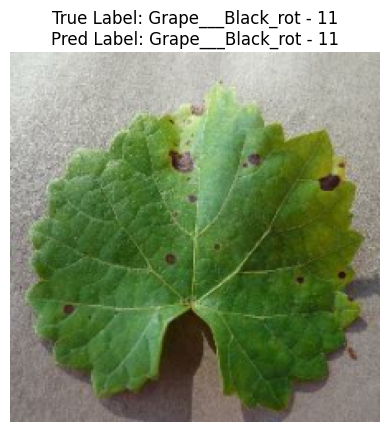

In [ ]:
pred_plot_image(model_3, unbatch_sample_images, unbatch_sample_labels, class_names)